# Generative Adversarial Networks (GANs)

So far all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. In this assignment, we will  build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real (1) vs. fake (0) as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__.
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.


In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

## Import Packages and define necessary Functions

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

## Dataset
we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images.
You need complete the code to create dataset and data loader. Use torchvision to do this. for transform only use the ToTensor().

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.8MB/s]


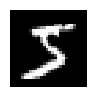

In [2]:

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

## Start Code Here ##
# mnist train dataset
mnist_train = dset.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=T.ToTensor()
)


# create train dataloader
loader_train = DataLoader(mnist_train, batch_size= batch_size, sampler= sampler.SubsetRandomSampler(range(NUM_TRAIN)))
# msnit test dataset
mnist_val = dset.MNIST(
    root="data",
    train= False,
    download=True,
    transform=T.ToTensor()
)
# create mnist dataloader
loader_val = DataLoader(mnist_val, batch_size= batch_size, sampler= sampler.SubsetRandomSampler(range(NUM_VAL)))
## End code here###
iter_mnist_train = iter(mnist_train)
imgs = next(iter_mnist_train)[0]
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Hint: use `torch.rand`.

In [3]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.

    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    ## start code here ###
    return 2 * torch.rand(batch_size, dim) - 1
    ## end code here ##


Make sure noise is the correct shape and type

## Flatten

Recall our Flatten operation from previous notebooks... this time we also provide an Unflatten, which you might want to use when implementing the generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

## CPU / GPU
By default all code will run on CPU. GPUs are not needed for this assignment, but will help you to train your models faster. If you do want to run the code on a GPU, then change the `dtype` variable in the following cell.

In [5]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

# Discriminator
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Flatten layer to convert the image to vector
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1

Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.

The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [6]:
def discriminator():
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 256),  # Maps the input features to 4096 neurons.
        nn.LeakyReLU(0.01),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.01),
        nn.Linear(256, 1))

        ## End Code Here ##

    return model

# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

In [7]:
def generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
       ## Start Code Here ##
       nn.Linear(noise_dim,1024),
       nn.ReLU(),
       nn.Linear(1024, 1024),
       nn.ReLU(),
       nn.Linear(1024,784),
       nn.Tanh(),
       ## End Code Here ##
    )
    return model

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.


In [8]:
## Start Code Here ##
# create a object of binary cross entropy loss from nn.BCELoss.


bce_loss = nn.BCEWithLogitsLoss()
## End Code Here ##

In [9]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.

    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.

    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    # Target label vector, the discriminator should be aiming
    ## Start Code Here ##
    # We know the truth label for discriminator is 0 (for fake data) and 1 ( for real data)
    # create a Varaiable by using Variable class in torch.autograd that contain the 1 label with the same shape of the logits_real
    true_labels = Variable(torch.ones_like(logits_real))
    fake_labels = Variable(torch.zeros_like(logits_fake))
    ## End Code Here ##
    # Discriminator loss has 2 parts: how well it classifies real images and how well it
    # classifies fake images.
    ## Start Code Here ##
    # use bce_loss to find the loss function for real image and fake image. For fake image loss you need to compare logits_fake with 0(truth label for fake image)
    real_image_loss = bce_loss(logits_real, true_labels)
    fake_image_loss = bce_loss(logits_fake, fake_labels)

    # Add to loss terms to made the full loss
    loss = real_image_loss + fake_image_loss
    ## End Code Here ##
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.

    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    # Generator is trying to make the discriminator output 1 for all its images.
    # So we create a 'target' label vector of ones for computing generator loss.
    ## Start Code Here
    # use Variable class in torch.autograd to cerate the label for generator loss
    true_labels = Variable(torch.ones_like(logits_fake))

    # Compute the generator loss compraing
    ## use bce_loss to find the loss value for generator
    loss = bce_loss(logits_fake, true_labels)

    ## End code Here
    return loss

# Optimizing our loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

In [10]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.

    Input:
    - model: A PyTorch model that we want to optimize.

    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    ### Start Code Here
    # Create a Adam optimizer with lr=0.001, betas=(0.5, 0.999) hyper parameters
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
    ## End Code Here
    return optimizer

# Training a GAN!

We provide you the main training loop... you won't need to change this function, but we encourage you to read through and understand it.

In [11]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250,
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = Variable(x).type(dtype)
            logits_real = D(2 * (real_data - 0.5)).type(dtype)

            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(), g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                fig = show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

Iter: 0, D: 1.43, G:0.6874


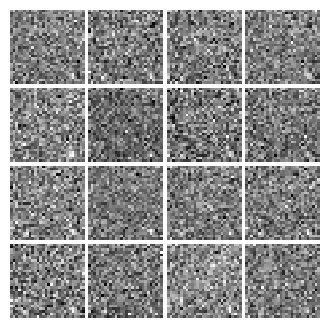


Iter: 250, D: 1.282, G:1.076


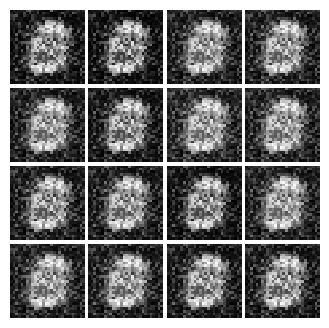


Iter: 500, D: 1.162, G:1.016


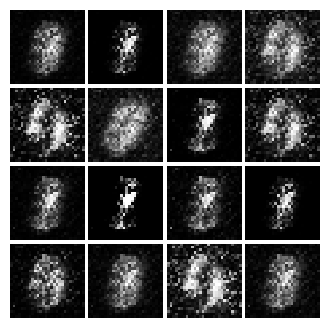


Iter: 750, D: 1.219, G:0.7869


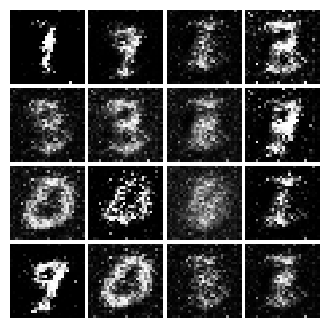


Iter: 1000, D: 1.219, G:1.373


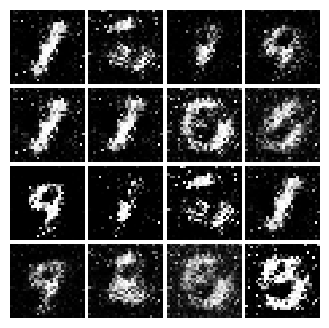


Iter: 1250, D: 1.181, G:1.718


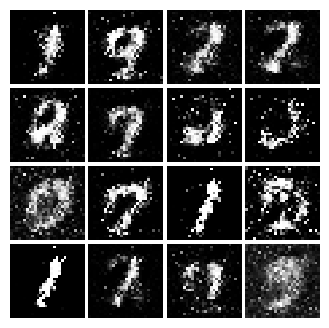


Iter: 1500, D: 1.312, G:0.9165


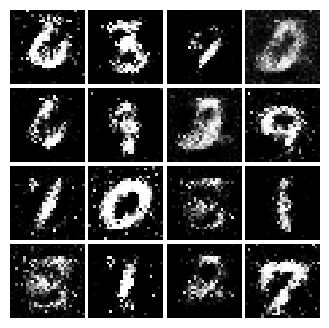


Iter: 1750, D: 1.149, G:0.7037


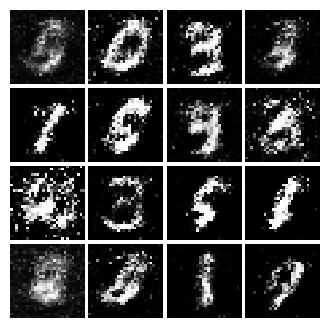


Iter: 2000, D: 1.144, G:1.024


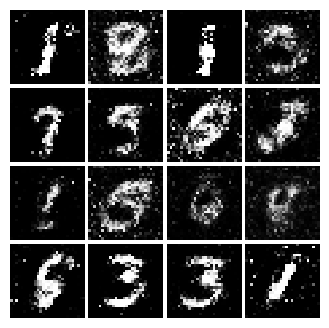


Iter: 2250, D: 1.297, G:0.9197


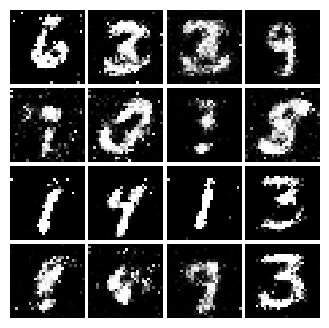


Iter: 2500, D: 1.217, G:0.9493


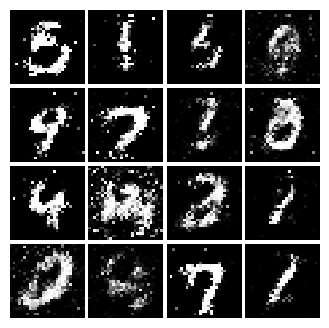


Iter: 2750, D: 1.33, G:0.772


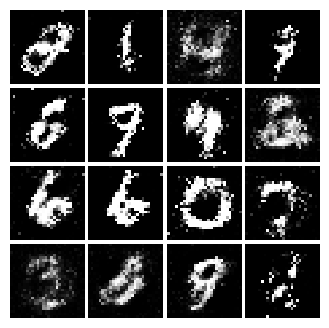


Iter: 3000, D: 1.31, G:0.7535


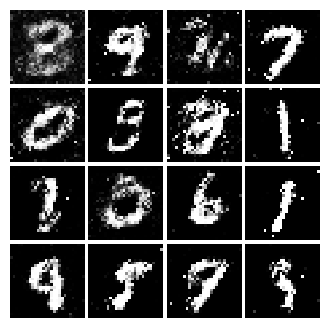


Iter: 3250, D: 1.376, G:0.8873


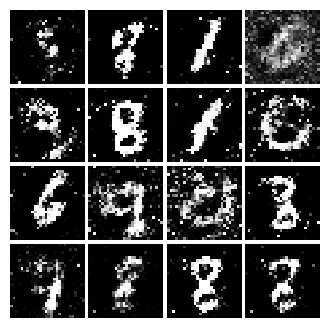


Iter: 3500, D: 1.269, G:0.7779


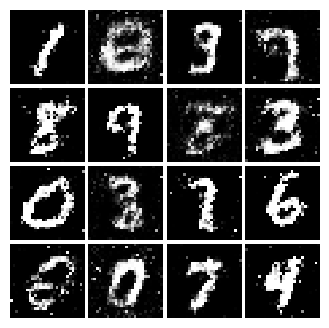


Iter: 3750, D: 1.34, G:0.8551


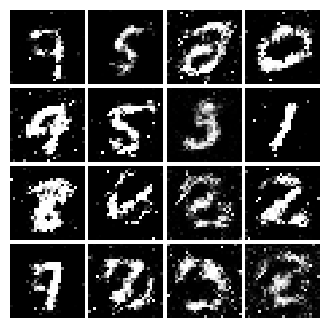

In [12]:
D = discriminator().type(dtype)
G = generator().type(dtype)

D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [14]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.

    Inputs:
    - scores_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.

    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    true_labels = Variable(torch.ones(scores_real.size())).type(dtype)
    ## Start Code Here
    fake_image_loss = torch.mean((scores_fake) ** 2)
    real_image_loss = torch.mean((scores_real - true_labels) ** 2)
    ## End Code Here
    loss = 0.5 * fake_image_loss + 0.5 * real_image_loss
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.

    Inputs:
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.

    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    true_labels = Variable(torch.ones(scores_fake.size())).type(dtype)
    ## Start Code Here
    loss = torch.mean((scores_fake - true_labels) ** 2)

    ## End Code Here
    return loss

Iter: 0, D: 0.4619, G:0.9386


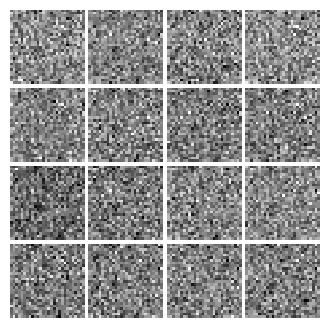


Iter: 250, D: 0.1228, G:0.733


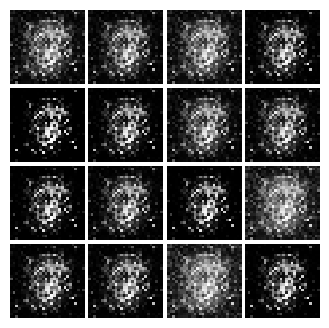


Iter: 500, D: 0.1132, G:0.7644


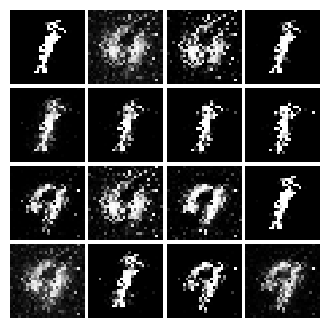


Iter: 750, D: 0.1879, G:0.4414


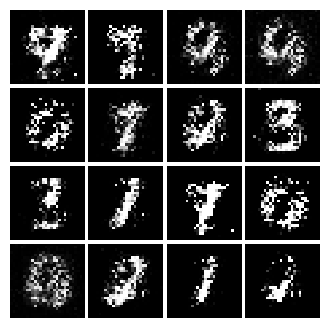


Iter: 1000, D: 0.1303, G:0.5714


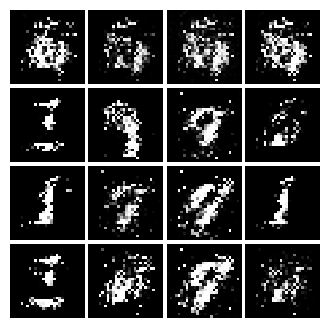


Iter: 1250, D: 0.1742, G:0.5776


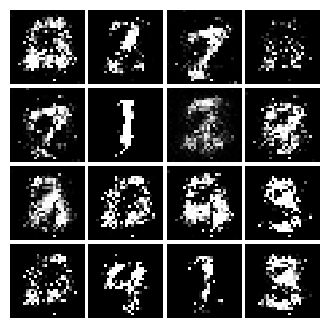


Iter: 1500, D: 0.205, G:0.4713


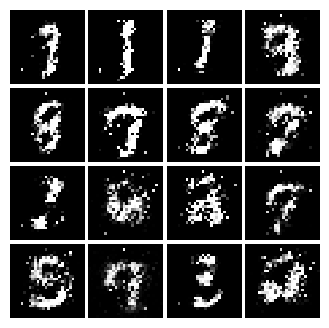


Iter: 1750, D: 0.2324, G:0.3089


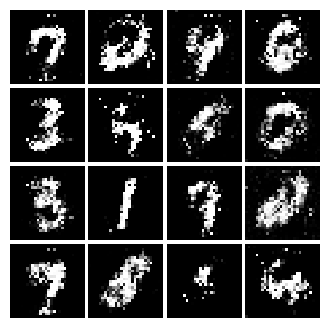


Iter: 2000, D: 0.2083, G:0.4853


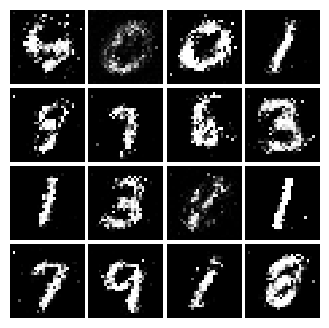


Iter: 2250, D: 0.2286, G:0.32


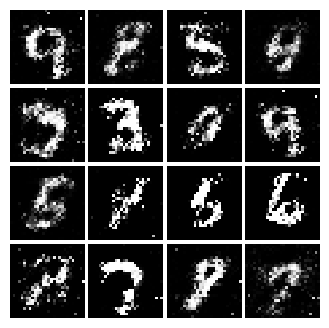


Iter: 2500, D: 0.236, G:0.3478


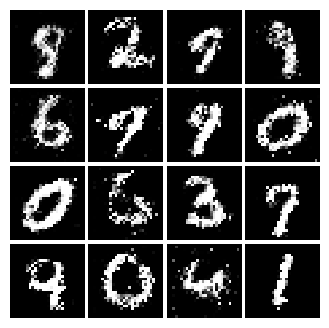


Iter: 2750, D: 0.2247, G:0.345


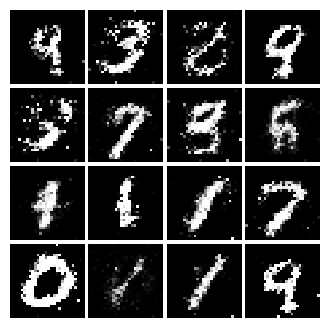


Iter: 3000, D: 0.2397, G:0.3672


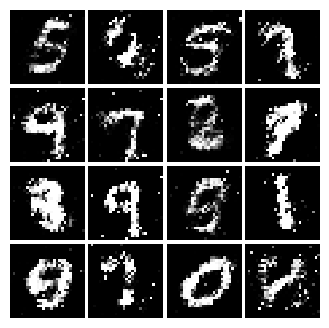


Iter: 3250, D: 0.2195, G:0.3297


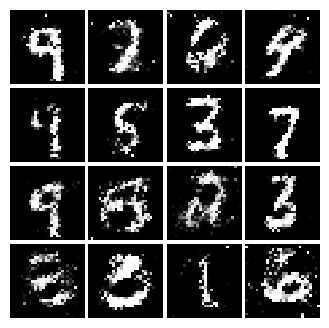


Iter: 3500, D: 0.2273, G:0.3282


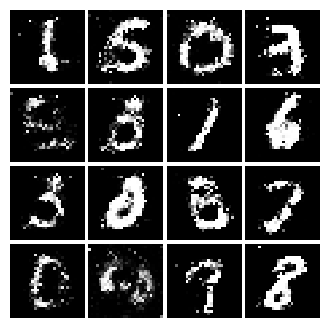


Iter: 3750, D: 0.2413, G:0.3488


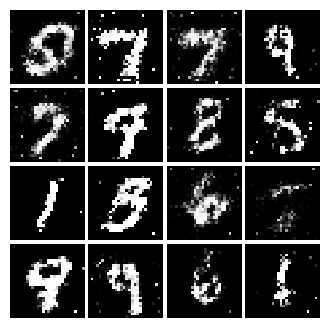

In [15]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss)

# Deeply Convolutional GANs
#### Discriminator
We will use the following discriminator
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

In [16]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        ## Start Code Here
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(kernel_size=2, stride=2),


        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(kernel_size=2, stride=2),


        nn.Flatten(),


        nn.Linear(4 * 4 * 64, 4 * 4 * 64),
        nn.LeakyReLU(0.01),

        nn.Linear(4 * 4 * 64, 1)


        ## End Code Here
    )

iter_loader_train = iter(loader_train)
data = Variable(next(iter_loader_train)[0]).type(dtype)
print(print(batch_size * 1 * 28* 28))
b = build_dc_classifier().type(dtype)
out = b(data)
print(out.size())


100352
None
torch.Size([128, 1])


#### Generator
For the generator we use following architecture
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128
* ReLU
* BatchNorm
* Reshape into Image Tensor of shape 7, 7, 128
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector

In [17]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return nn.Sequential(
       ## Start Code Here


        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),


        nn.Linear(1024, 7 * 7 * 128),
        nn.ReLU(),
        nn.BatchNorm1d(7 * 7 * 128),


        Unflatten(N=-1, C=128, H=7, W=7),


        nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        ),
        nn.ReLU(),
        nn.BatchNorm2d(64),


        nn.ConvTranspose2d(
            in_channels=64,
            out_channels=1,
            kernel_size=4,
            stride=2,
            padding=1
        ),
        nn.Tanh(),

        nn.Flatten()

       ## End Code Here
    )

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = Variable(torch.randn(batch_size, NOISE_DIM)).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Iter: 0, D: 1.347, G:0.8256


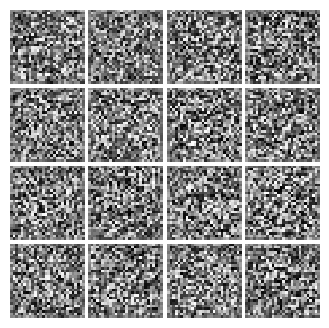


Iter: 250, D: 1.255, G:0.9881


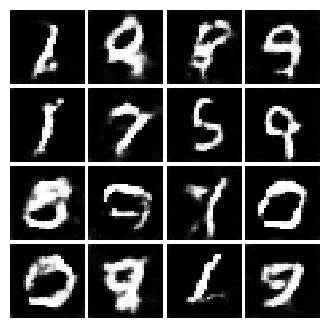


Iter: 500, D: 1.147, G:1.064


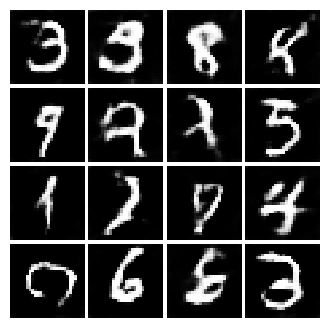


Iter: 750, D: 1.255, G:0.9703


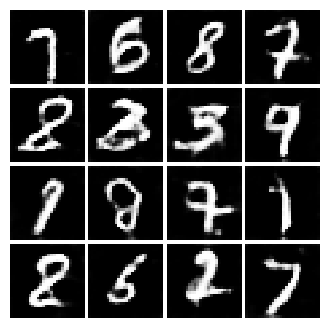


Iter: 1000, D: 1.172, G:0.8542


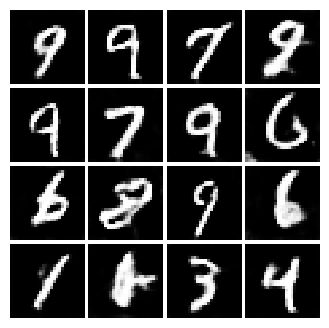


Iter: 1250, D: 1.201, G:0.8098


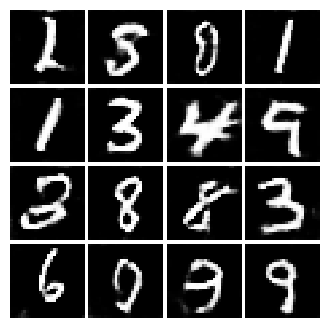


Iter: 1500, D: 1.16, G:0.9352


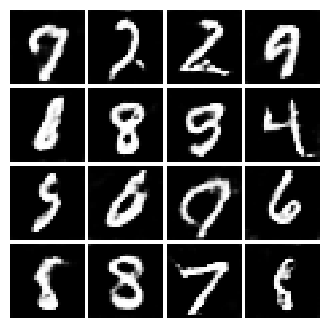


Iter: 1750, D: 1.222, G:0.9941


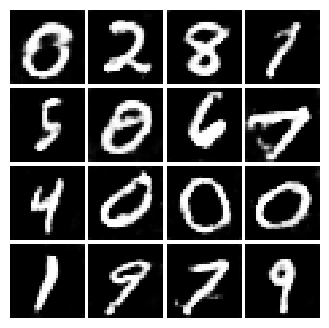


Iter: 2000, D: 1.077, G:1.21


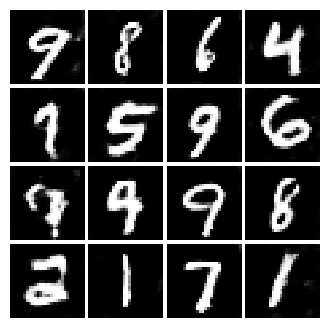


Iter: 2250, D: 1.084, G:0.8342


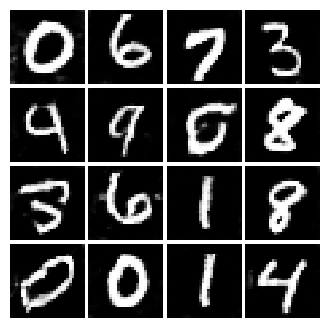


Iter: 2500, D: 1.113, G:1.751


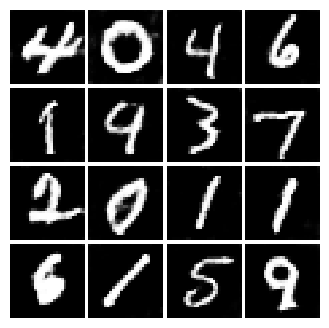


Iter: 2750, D: 0.9462, G:1.722


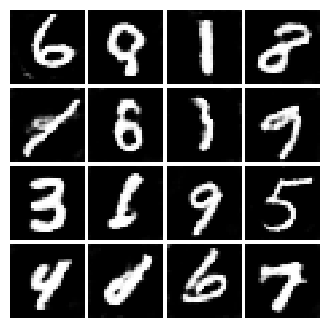


Iter: 3000, D: 1.03, G:1.608


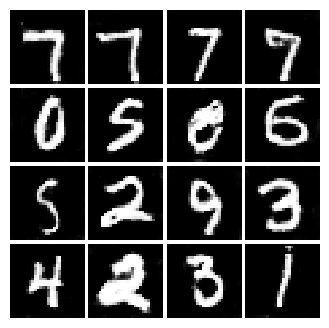


Iter: 3250, D: 1.16, G:1.092


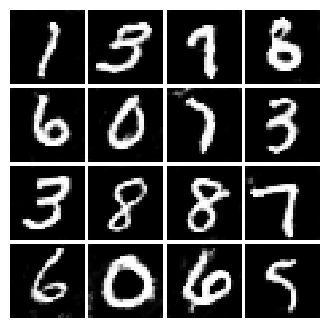


Iter: 3500, D: 1.012, G:1.421


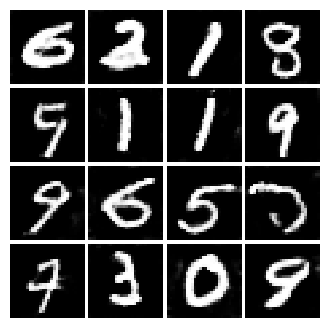


Iter: 3750, D: 1.03, G:1.379


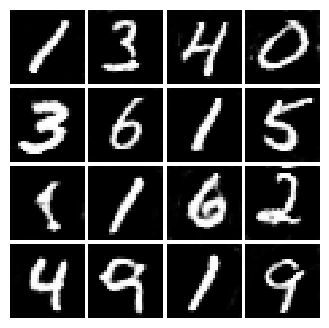

In [18]:
D_DC = build_dc_classifier().type(dtype)
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss) #, num_epochs=5)

## Tasks for report:
1) You need to compare implemented loss functions in the report.
2) Write the inference code for using a trained generator to generate an image and then show it in this notebook. Put that inference code in the report.
3) Generate images using the written inference code for all the methods above and put them in your report with comments.

# Lab Report Questions

Please answer the following questions in your lab report. Your answers should be based on your observations during training. The viva in the lab will also include the concepts discussed in the questions below so prepare well.

### 1. Architecture Comparison: Dense vs. Convolutional
**Question:** Compare the generated image quality between the first GAN (using fully connected layers) and the DCGAN (using convolutional layers).
* **Visual Analysis:** Which model produced sharper, more coherent digits?
* **Conceptual:** Discuss how layers like `Conv2DTranspose` and the preservation of spatial structure contribute to this difference.

---

### 2. Analyzing Loss Functions: Standard vs. Least Squares
**Question:** You implemented both the standard Minimax Loss and the Least Squares Loss (LSGAN).
* **Theoretical:** What specific problem with the standard GAN loss (sigmoid cross-entropy) does the Least Squares GAN attempt to solve? (Hint: Consider the gradient magnitude when the discriminator is very confident).
* **Observation:** Did you notice a difference in training stability or the quality of results between the two loss functions in your experiments?

---

### 3. The "Minimax" Dynamic
**Question:** In the `run_a_gan` function, the discriminator and generator are updated in an alternating fashion.
* **Scenario:** Suppose the Discriminator becomes "too perfect" very early in training (i.e., its loss drops to nearly 0 immediately). Why is this actually *bad* for the training of the Generator?
* **Mechanics:** Explain how the Generator learns. If the Discriminator outputs a probability of exactly 0.0 for all fake images, what happens to the gradients flowing back to the Generator?
---

### 4. Latent Space Interpolation
**Question:** Using the inference code you wrote for the final task, perform a "Latent Space Interpolation":
1. Sample two random noise vectors, $z_1$ and $z_2$.
2. Create 5-7 intermediate vectors using linear interpolation: $z_{new} = \alpha \cdot z_1 + (1-\alpha) \cdot z_2$ where $\alpha$ goes from 0 to 1.
3. Feed these vectors into your trained Generator and display the resulting strip of images.

**Report:** Do the digits morph smoothly from one number to another (e.g., a 7 slowly turning into a 9), or do they change abruptly? What does this imply about whether the network has learned a meaningful continuous representation of the data?

---

### 5. Mode Collapse and Diversity
**Question:** A common failure mode in GANs is "Mode Collapse."
* **Definition:** Define Mode Collapse in your own words.
* **Observation:** Look at a batch of 16 images generated by your best model. Is there a good variety of digits (0–9), or does the model seem to prefer generating only specific numbers?

